In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from functions import norm, norm_inv, box_cox
from tqdm import tqdm
import math
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import quantile_transform

from scipy import stats

In [2]:
labels = ["Higgs $p_T$", "Higgs $\eta$", "Higgs $\phi$",
             "Top $p_T$", "Top $\eta$", "Top $\phi$",
            "Anti-Top $p_T$", "Anti-Top $\eta$", "Anti-Top $\phi$"]

s_name  = []
s_value = []

In [3]:
df = pd.read_feather('/scratch365/cmcgrad2/data/dataframes/rc_ctq8*SM.feather').rename(columns={'ctq8*SM':'r_c'})
df = df.iloc[:, [0,1,2,4,5,6,8,9,10,12]]
df = df[(df['Higgs eta'] >= -2.5) & (df['Higgs eta'] <= 2.5) &
        (df['Top eta'] >= -2.5) & (df['Top eta'] <= 2.5) &
        (df['Anti-Top eta'] >= -2.5) & (df['Anti-Top eta'] <= 2.5)]
df

,Higgs pt,Higgs eta,Higgs phi,Top pt,Top eta,Top phi,Anti-Top pt,Anti-Top eta,Anti-Top phi,r_c
0,477.00,-1.769531,0.878906,612.00,-0.566406,-2.390625,151.000,-1.972656,0.256836,8.829590e-06
1,93.50,0.119385,-1.183594,172.50,-0.742188,0.247070,163.500,0.744141,-2.937500,1.400870e-13
2,363.00,-1.054688,-2.250000,184.50,-2.039062,-0.026978,277.000,-0.384766,1.507812,6.007150e-14
3,122.50,1.480469,-1.015625,313.00,0.796875,-0.943359,459.000,1.207031,2.132812,1.837720e-14
4,201.50,0.165527,-1.507812,123.75,-0.904297,1.289062,123.500,-0.246094,1.878906,6.874279e-08
...,...,...,...,...,...,...,...,...,...,...
15931394,148.00,-1.585938,2.031250,84.50,-2.257812,-1.359375,83.750,-2.445312,-1.375000,-2.506243e-15
15931396,112.75,0.330078,-2.046875,950.00,0.431641,-1.121094,840.000,-1.394531,1.984375,3.644979e-06
15931397,76.75,1.375000,1.312500,167.00,1.007812,-1.480469,145.500,-0.295898,2.078125,-4.099541e-14
15931399,74.50,-0.245117,1.703125,154.00,1.144531,-1.300781,42.875,0.896484,3.125000,-1.701319e-14


In [ ]:
pp = PdfPages('plots/ctq8*SM_transformations.pdf')

In [5]:
def plot(df, name, filename):
    stat = df.agg(['skew', 'kurtosis']).transpose()
    k = stats.normaltest(df['r_c'].to_numpy())[0]

    s_name.append(name)
    s_value.append(k)

    plt.rcParams['figure.figsize'] = [15, 8]

    n, bins, patches = plt.hist(df['r_c'], 100, density=False, alpha=0.75)

    xlim = np.min(bins)
    ylim = np.max(n)

    plt.text(xlim, ylim*0.03,
             'Data Statistics' + '\n' + 
             'Skew: ' + str(stat['skew']['r_c'].round(decimals=2)) + '\n' + 
             'Excess Kurtosis: '+ str((stat['kurtosis']['r_c']-3).round(decimals=2)) + '\n' +
             '$K^2$: ' + str("{:,}".format(k.round(decimals=0))) + '\n' +
             '$\Delta K^2$: ' + str("{:,}".format((k - start).round(decimals=0))),
             style='italic', fontsize=12,
             bbox={'facecolor': 'white', 'alpha': 1, 'pad': 15})

    plt.xlabel('$\mathregular{r_c}$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Outputs After ' + name, fontsize=16)
    plt.yscale('log')
    plt.grid(True)
    plt.savefig('plots/individual_plots/ctq8*SM_' + filename + '_outputs.png')
    pp.savefig()

# Looking at the Original Data Without Filtering

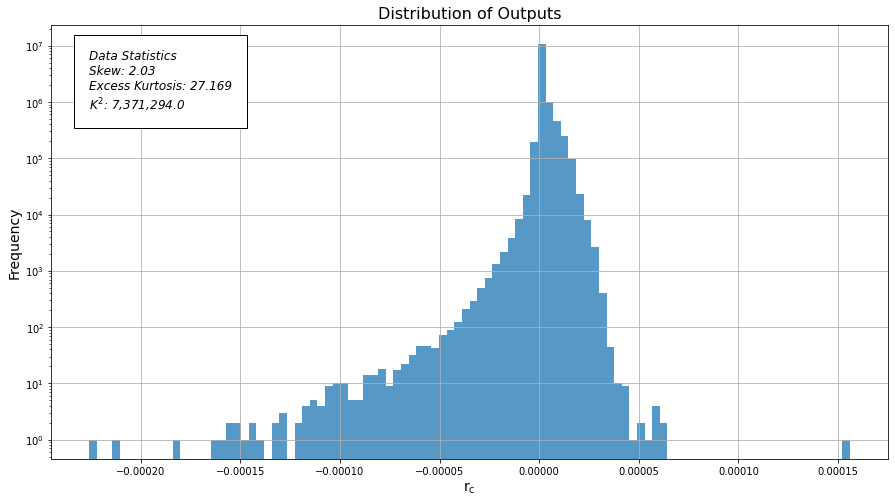

In [6]:
stat_orig = df.agg(['skew', 'kurtosis']).transpose()
start = stats.normaltest(df['r_c'].to_numpy())[0]

plt.rcParams['figure.figsize'] = [15, 8]

n, bins, patches = plt.hist(df['r_c'], 100, density=False, alpha=0.75)

xlim = np.min(bins)
ylim = np.max(n)

plt.text(xlim, ylim*0.07,
         'Data Statistics' + '\n' + 
         'Skew: ' + str(stat_orig['skew']['r_c'].round(decimals=2)) + '\n' + 
         'Excess Kurtosis: '+ str((stat_orig['kurtosis']['r_c'] - 3).round(decimals=3)) + '\n' +
         '$K^2$: ' + str("{:,}".format(start.round(decimals=0))),
         style='italic', fontsize=12,
         bbox={'facecolor': 'white', 'alpha': 1, 'pad': 15})

plt.xlabel('$\mathregular{r_c}$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Outputs', fontsize=16)
plt.yscale('log')
plt.grid(True)
plt.savefig('plots/individual_plots/ctq8*SM_outputs.png')
pp.savefig()

## Taking the Natural Log of the Data

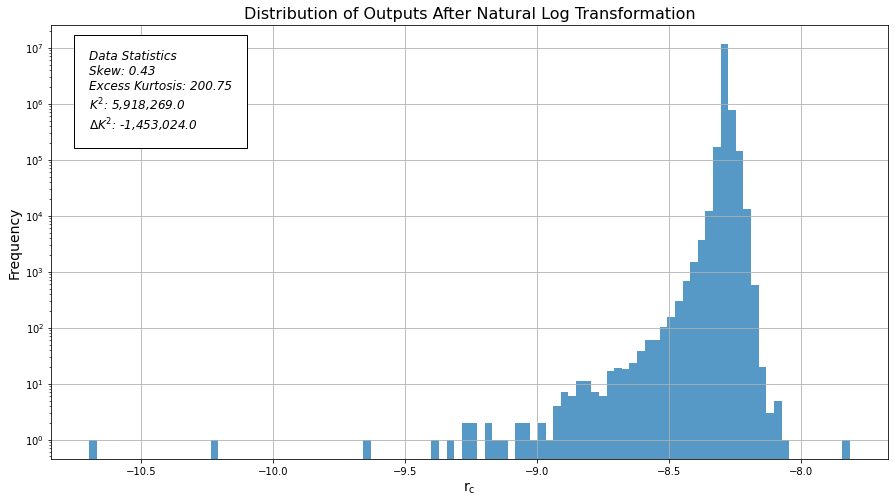

In [7]:
trans = df.copy(deep=True)
trans['r_c'] = np.log(trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy())*1.1)

plot(trans, 'Natural Log Transformation', 'log')

## Standard Normalization of the Data

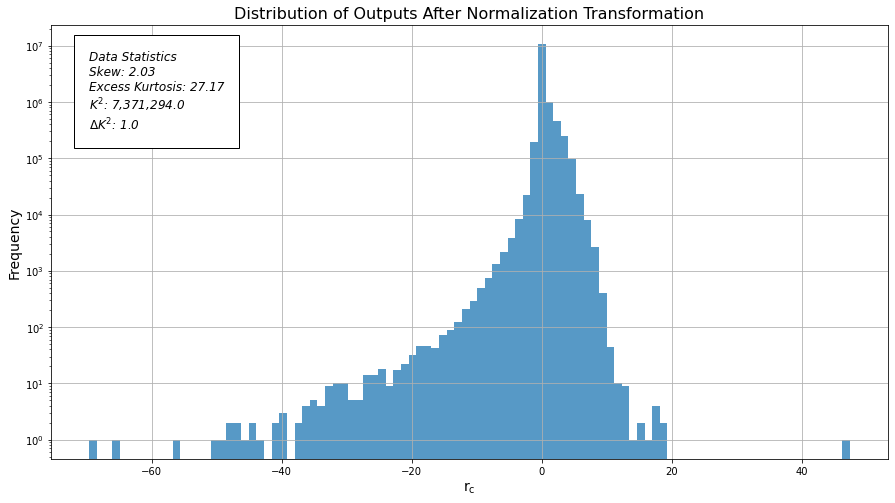

In [8]:
trans = df.copy(deep=True)
(trans, std, mean) = norm(df)

plot(trans, 'Normalization Transformation', 'norm')

## Pearson R Box-Cox Transformation

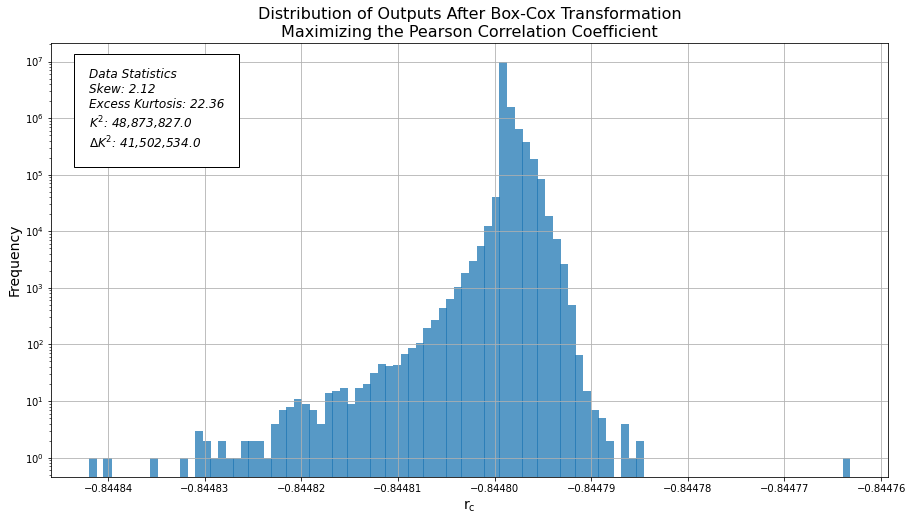

In [9]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.1)
pearsonr = stats.boxcox_normmax(trans['r_c'], method='pearsonr')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=pearsonr, alpha=None)

plot(trans, 'Box-Cox Transformation'  + '\n' +  
     'Maximizing the Pearson Correlation Coefficient', 'p_box_cox')

## Natural Log of Pearson R Box-Cox Transformation

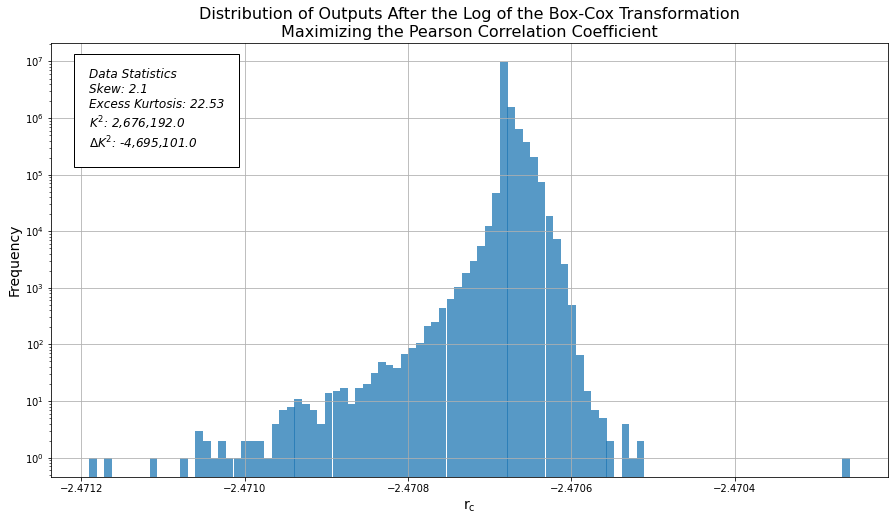

In [10]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.1)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Box-Cox Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient', 'log_p_box_cox')

## MLE Box-Cox Transformation

In [11]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
mle = stats.boxcox_normmax(trans['r_c'], method='mle')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=mle, alpha=None)

#plot(trans, 'Distribution of Outputs After Box-Cox Transformation' + '\n' + 
#     'Minimizing the Log-Likelihood', 'mle_box_cox')

/usr/local/lib64/python3.6/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/usr/local/lib64/python3.6/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/usr/local/lib64/python3.6/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/usr/local/lib64/python3.6/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


## Natural Log of MLE Box-Cox Transformation

In [12]:
trans['r_c'] = np.log(trans['r_c'].to_numpy())

#plot(trans, 'Distribution of Outputs After the Log of the Box-Cox Transformation' + '\n' + 
#     'Minimizing the Log-Likelihood', 'log_mle_box_cox')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


## Pearson R Yeo-Johnson Transformation

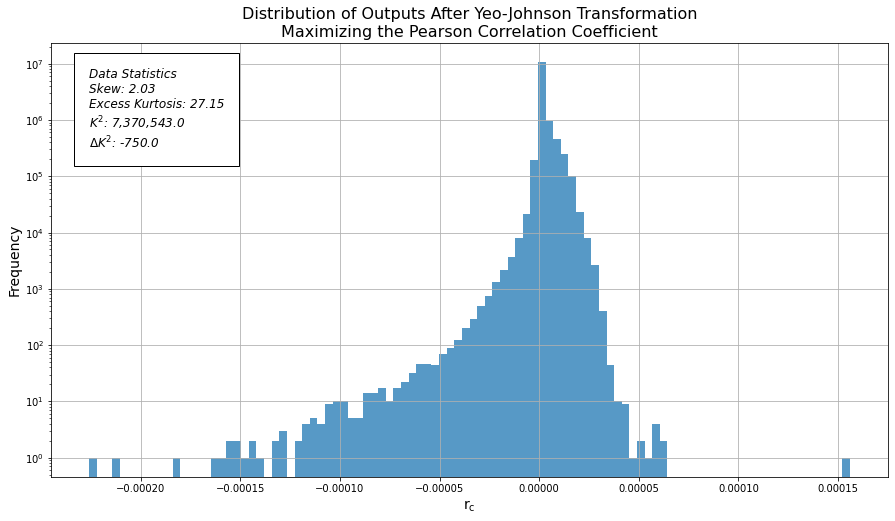

In [14]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=pearsonr)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient', 'p_yeo')

## Natural Log of  Yeo-Johnson Transformation

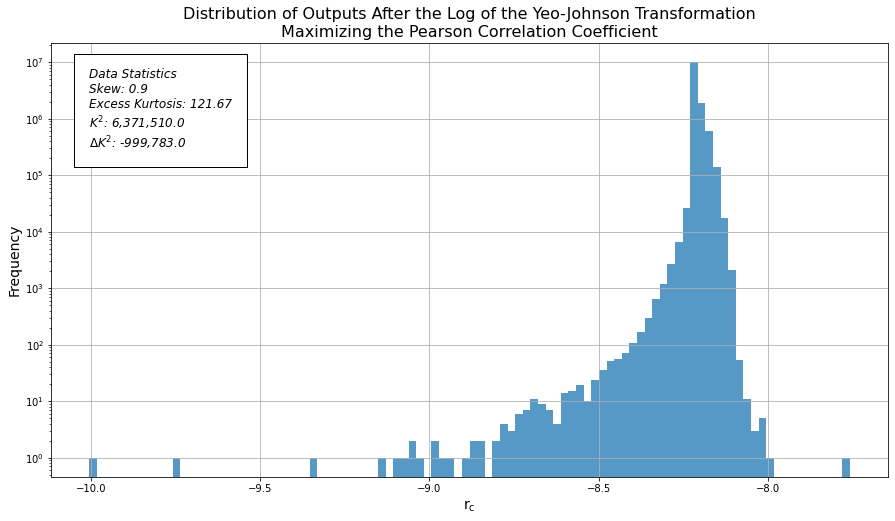

In [15]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient', 'log_p_yeo')

## MLE Yeo-Johnson Transformation

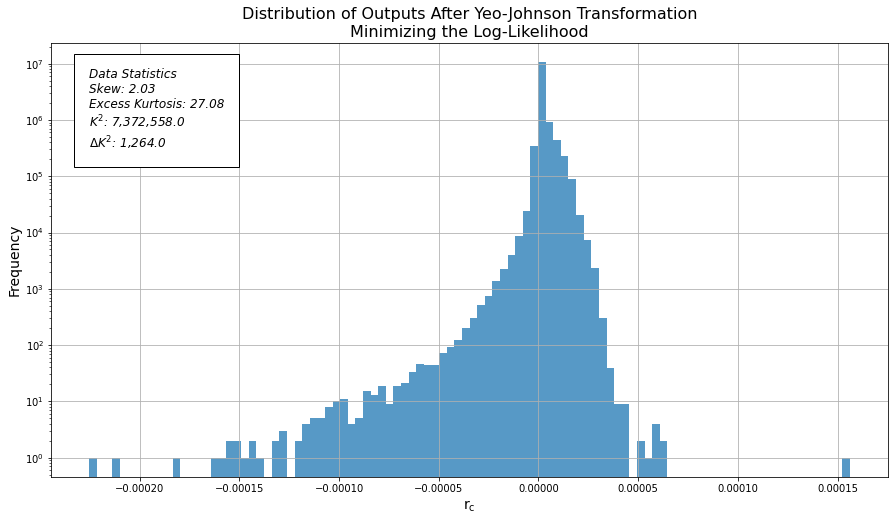

In [16]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=mle)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood', 'mle_yeo')

## Natural Log of MLE Yeo-Johnson Transformation

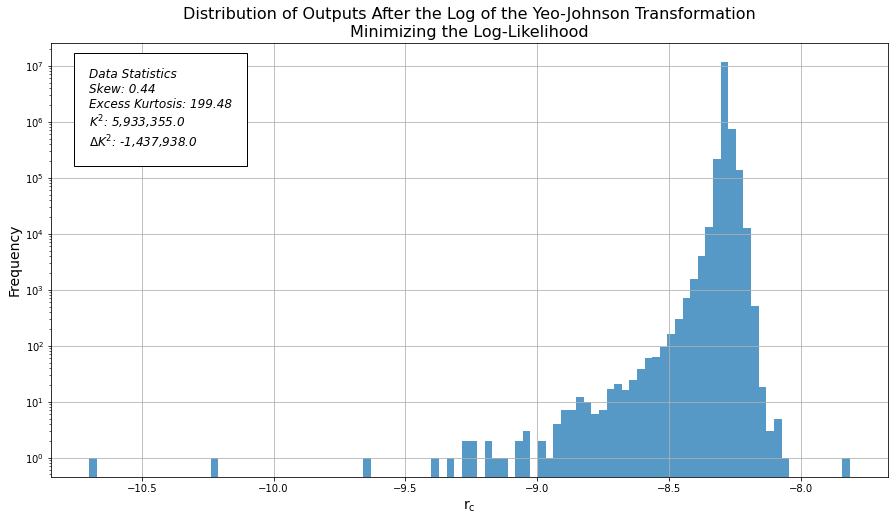

In [17]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.1)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood', 'log_mle_yeo')

## Normal Quantile Transformed

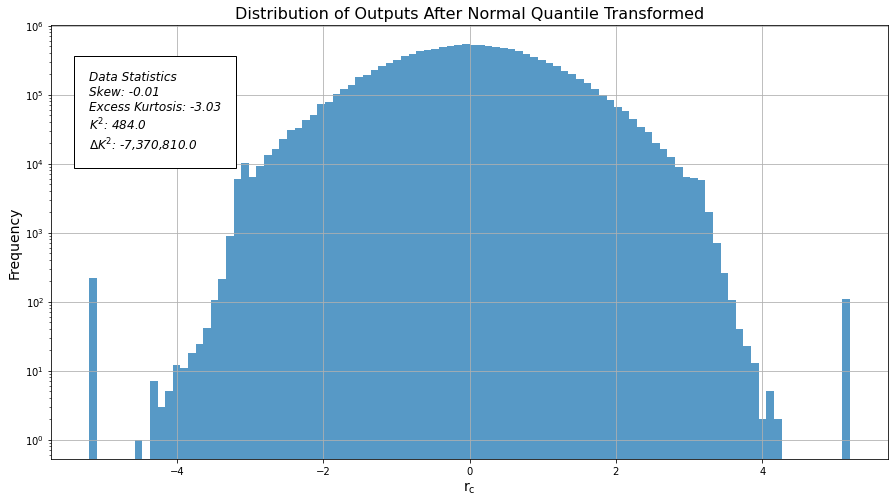

In [18]:
trans = df.copy(deep=True)
trans['r_c'] = quantile_transform(trans['r_c'].to_numpy().reshape(-1, 1), output_distribution='normal', copy=True)

plot(trans, 'Normal Quantile Transformed', 'norm_quantile')

# Filtering the Data

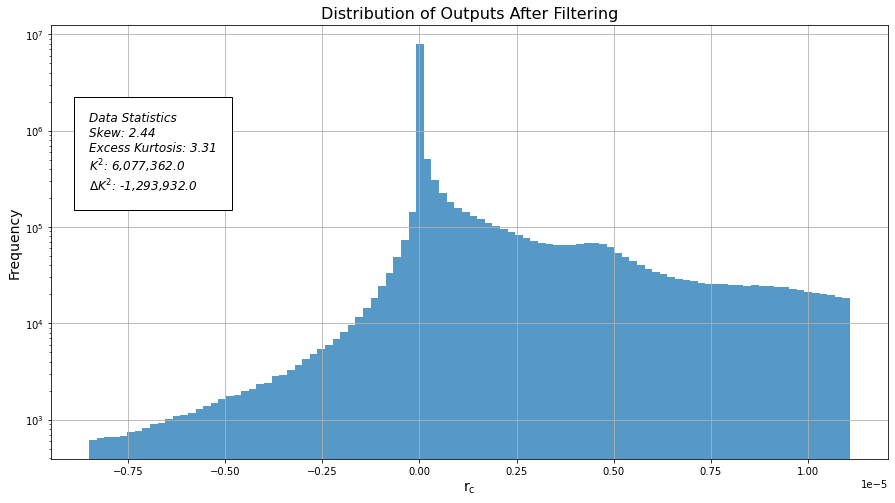

In [19]:
df = df[(df['r_c'] >= (df.mean()['r_c'] - 3*df.std()['r_c'])) & 
         (df['r_c'] <= (df.mean()['r_c'] + 3*df.std()['r_c']))]

plot(df, 'Filtering', 'filt')

## Taking the Natural Log of the Data

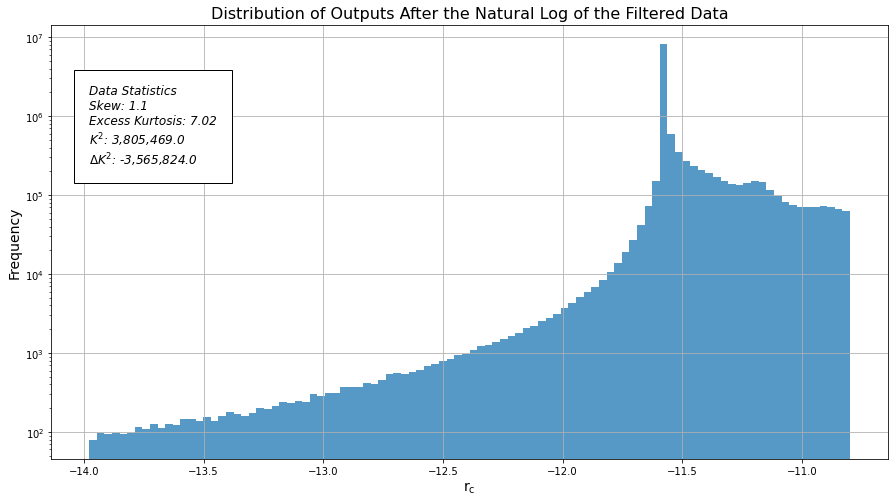

In [20]:
trans = df.copy(deep=True)
trans['r_c'] = np.log(trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy())*1.2)

plot(trans, 'the Natural Log of the Filtered Data', 'log_filt')

## Standard Normalization of the Data

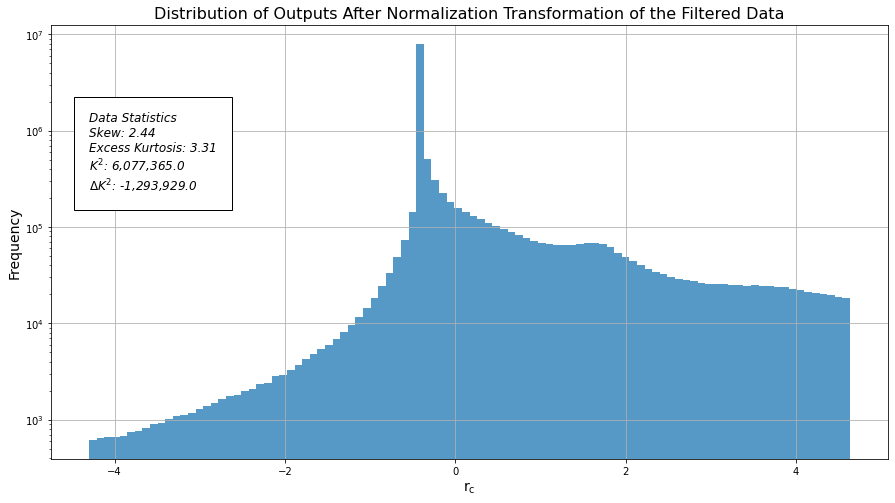

In [21]:
trans = df.copy(deep=True)
(trans, std, mean) = norm(df)

plot(trans, 'Normalization Transformation of the Filtered Data', 'norm_filt')

## Pearson R Box-Cox Transformation

/usr/local/lib64/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


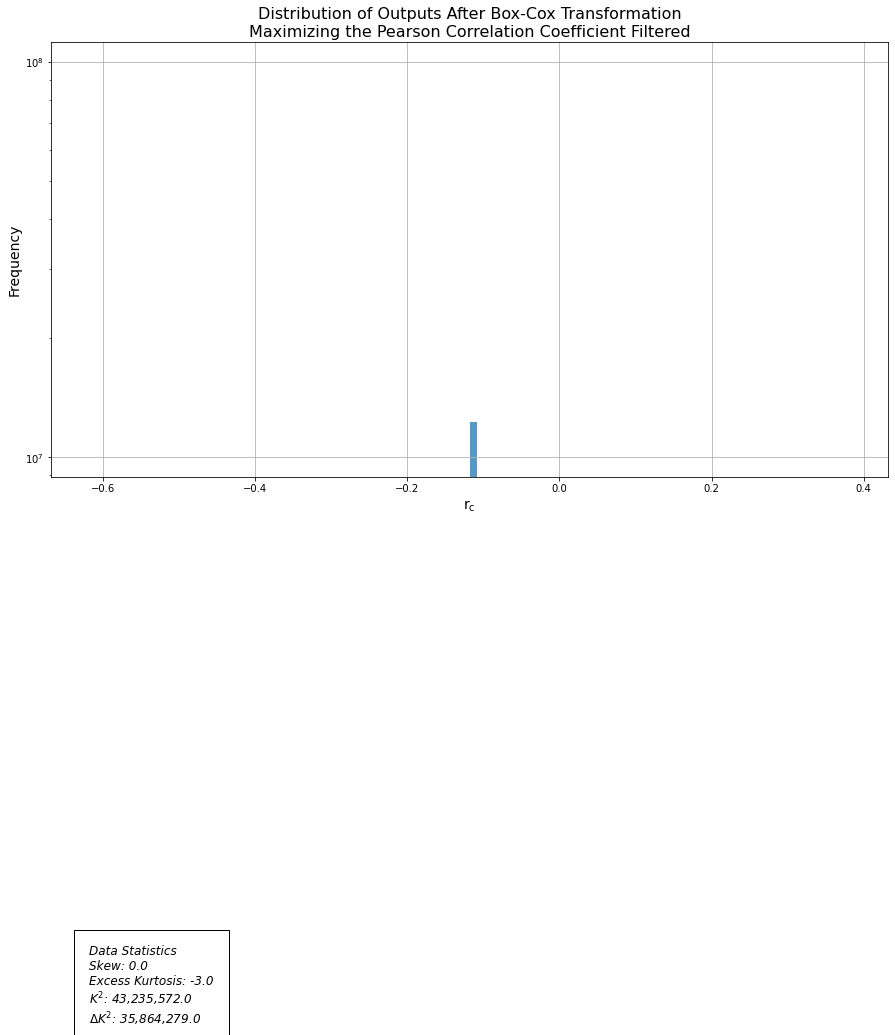

In [22]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
pearsonr = stats.boxcox_normmax(trans['r_c'], method='pearsonr')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=pearsonr, alpha=None)

plot(trans,  'Box-Cox Transformation' + '\n' + 
          'Maximizing the Pearson Correlation Coefficient Filtered', 'p_box_cox_filt')

## Natural Log of Pearson R Box-Cox Transformation

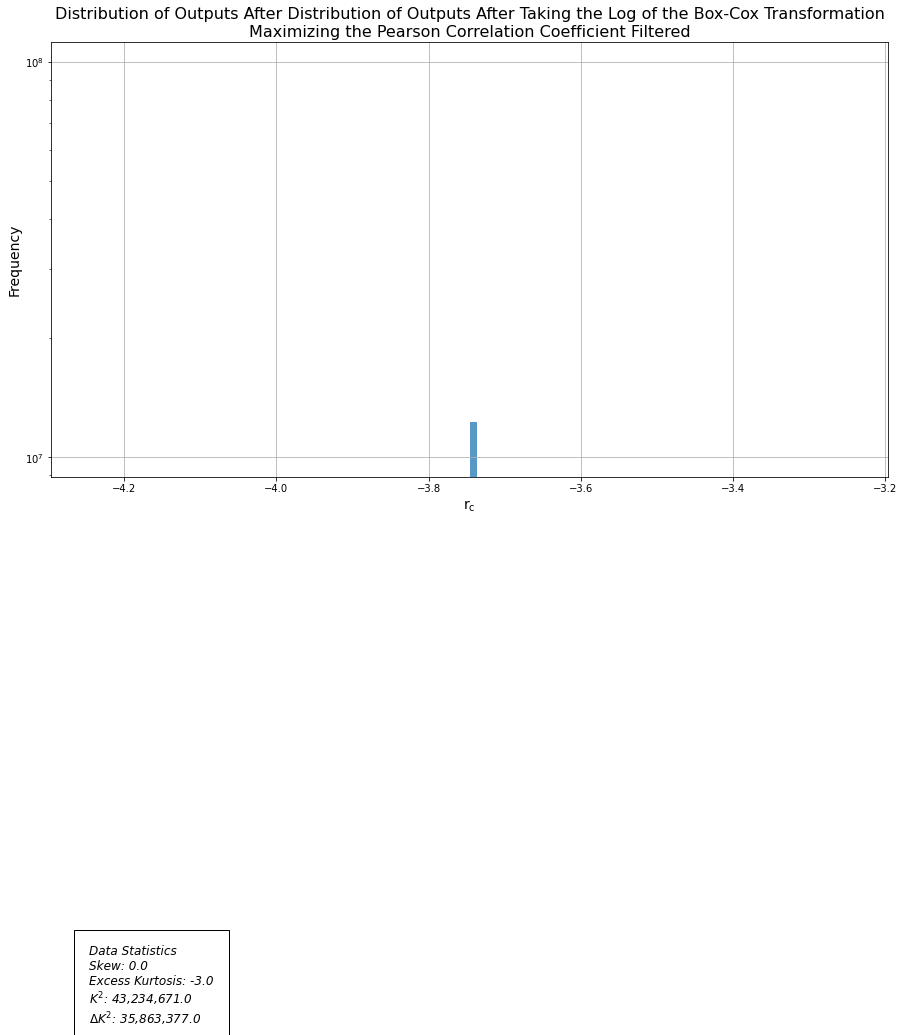

In [23]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'Distribution of Outputs After Taking the Log of the Box-Cox Transformation' + '\n' +
          'Maximizing the Pearson Correlation Coefficient Filtered', 'log_p_box_cox_filt')

## Pearson R Box-Cox Transformation

/usr/local/lib64/python3.6/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/usr/local/lib64/python3.6/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/usr/local/lib64/python3.6/site-packages/scipy/optimize/optimize.py:1984: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/usr/local/lib64/python3.6/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


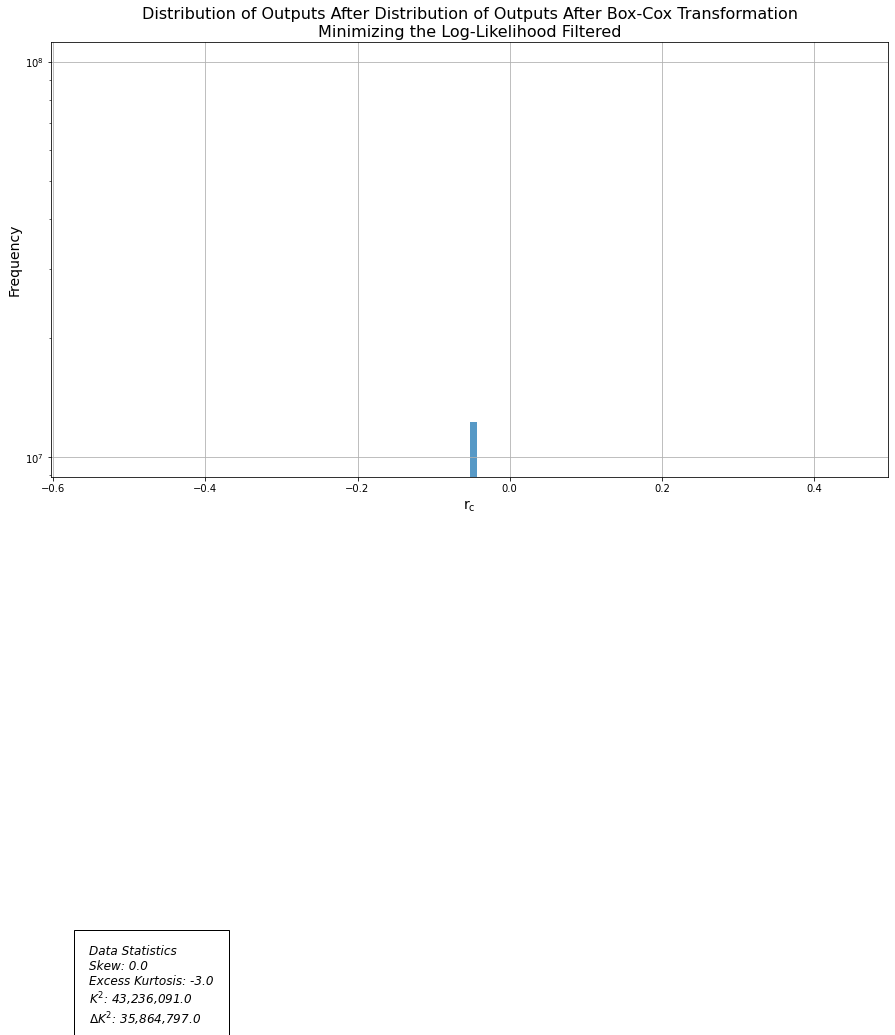

In [24]:
trans = df.copy(deep=True)
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
mle = stats.boxcox_normmax(trans['r_c'], method='mle')
trans['r_c'] = stats.boxcox(trans['r_c'].to_numpy(), lmbda=mle, alpha=None)

plot(trans, 'Distribution of Outputs After Box-Cox Transformation' + '\n' +  
          'Minimizing the Log-Likelihood Filtered', 'mle_box_cox_filt')

## Log Pearson R Box-Cox Transformation

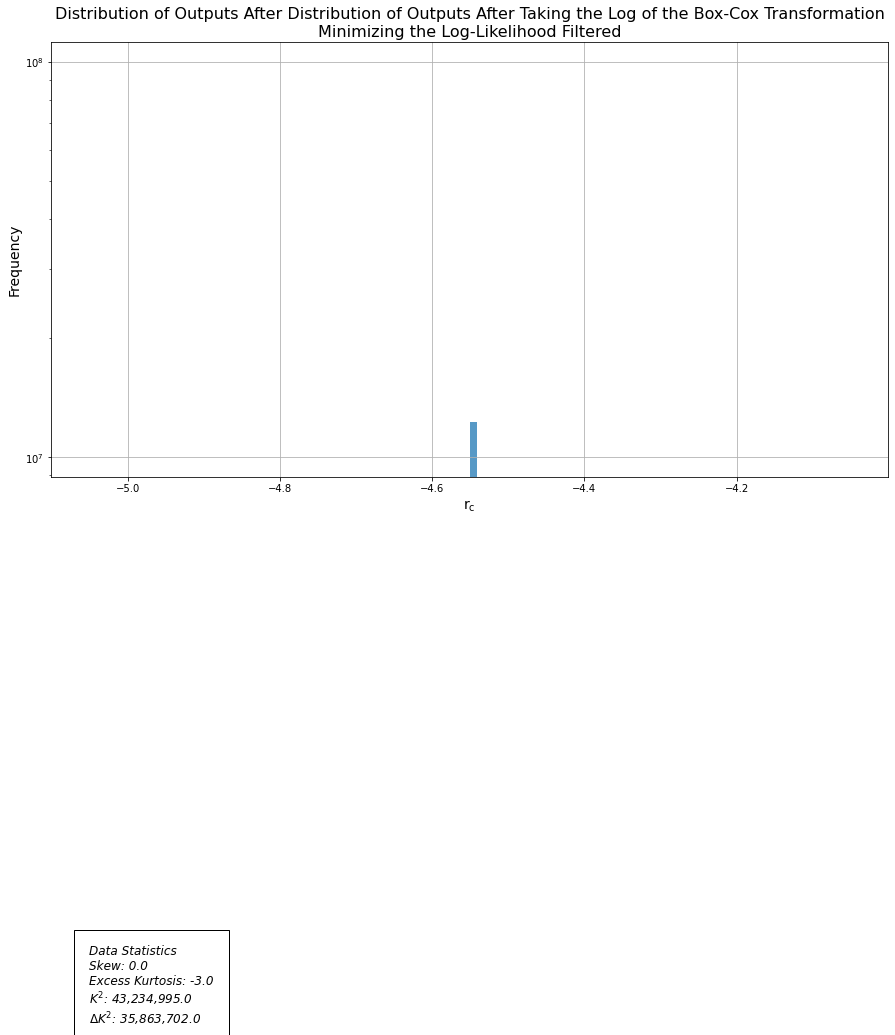

In [25]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'Distribution of Outputs After Taking the Log of the Box-Cox Transformation' + '\n' + 
          'Minimizing the Log-Likelihood Filtered', 'log_mle_box_cox_filt')

## Pearson R Yeo-Johnson Transformation

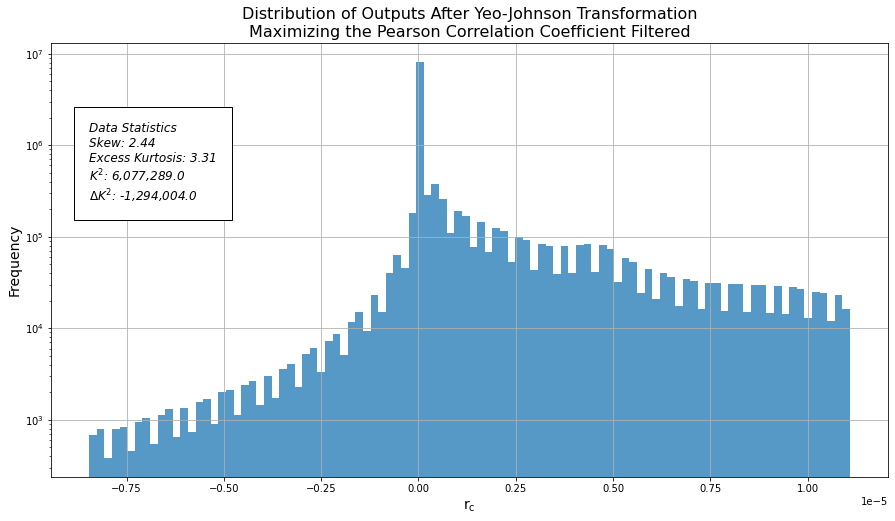

In [26]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=pearsonr)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient Filtered', 'p_yeo_filt')

## Natural Log of Pearson R Yeo-Johnson Transformation

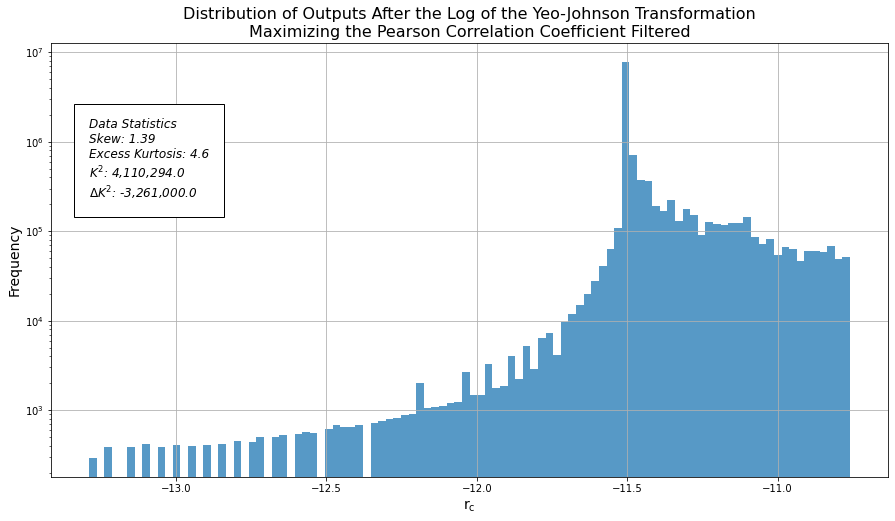

In [27]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Maximizing the Pearson Correlation Coefficient Filtered', 'log_p_yeo_filt')

## MLE Yeo-Johnson Transformation

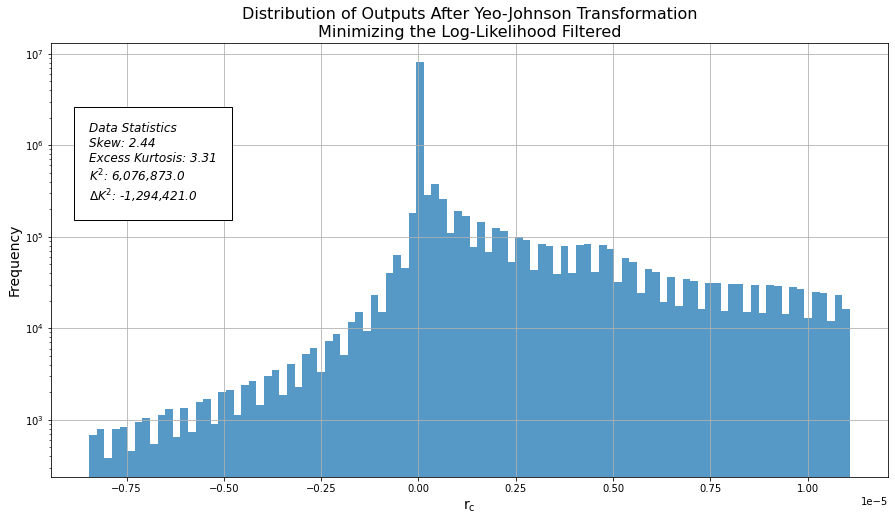

In [28]:
trans = df.copy(deep=True)
trans['r_c'] = stats.yeojohnson(trans['r_c'].to_numpy(), lmbda=mle)

plot(trans, 'Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood Filtered', 'mle_yeo_filt')

## Natural Log of MLE Yeo-Johnson Transformation

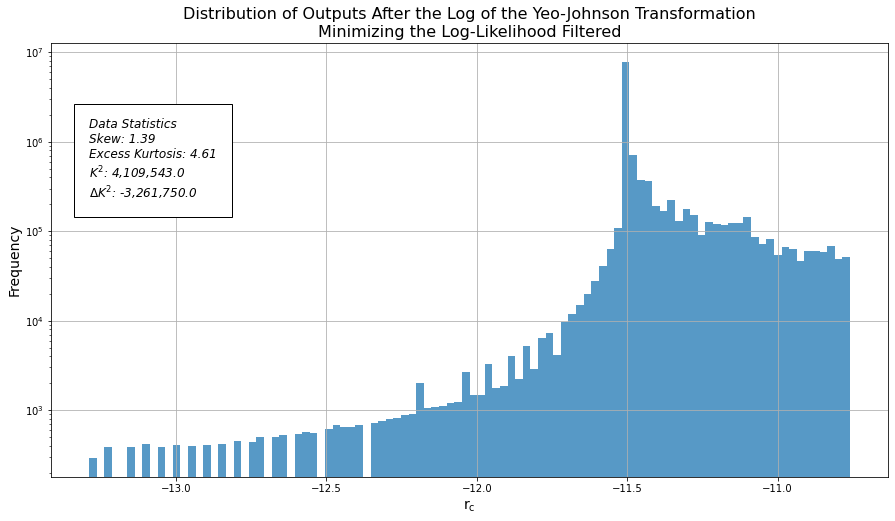

In [29]:
trans['r_c'] = trans['r_c'].to_numpy() - np.min(trans['r_c'].to_numpy()*1.2)
trans['r_c'] = np.log(trans['r_c'].to_numpy())

plot(trans, 'the Log of the Yeo-Johnson Transformation' + '\n' +
     'Minimizing the Log-Likelihood Filtered', 'log_mle_yeo_filt')

## Normal Quantile Transformed

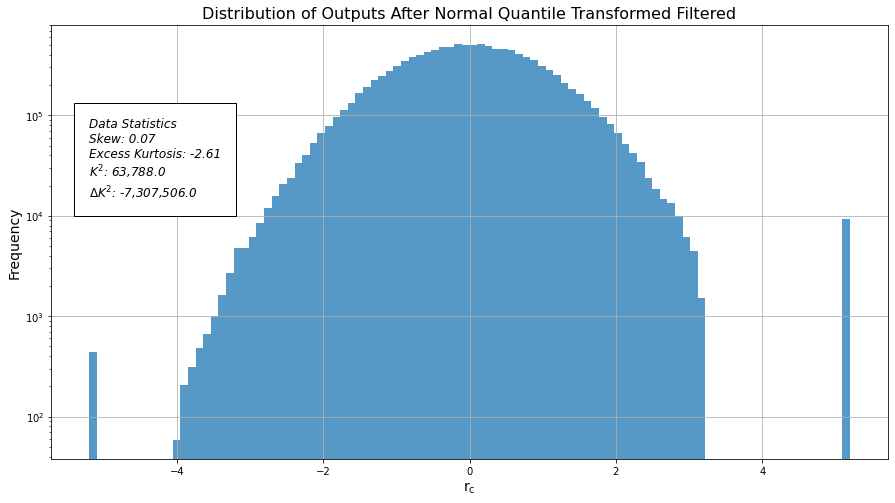

In [30]:
trans = df.copy(deep=True)
trans['r_c'] = quantile_transform(trans['r_c'].to_numpy().reshape(-1, 1), output_distribution='normal', copy=True)

plot(trans, 'Normal Quantile Transformed Filtered', 'norm_quantile_filt')

In [31]:
pp.close()

In [32]:
s_name

['Natural Log Transformation',
 'Normalization Transformation',
 'Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient',
 'the Log of the Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient',
 'Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient',
 'the Log of the Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient',
 'Yeo-Johnson Transformation\nMinimizing the Log-Likelihood',
 'the Log of the Yeo-Johnson Transformation\nMinimizing the Log-Likelihood',
 'Normal Quantile Transformed',
 'Filtering',
 'the Natural Log of the Filtered Data',
 'Normalization Transformation of the Filtered Data',
 'Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient Filtered',
 'Distribution of Outputs After Taking the Log of the Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient Filtered',
 'Distribution of Outputs After Box-Cox Transformation\nMinimizing the Log-Likelihood Filtered',
 

In [33]:
s_value

[5918269.180664908,
 7371294.437036287,
 48873827.3766577,
 2676192.303318199,
 7370543.13191234,
 6371510.1386245005,
 7372557.534411447,
 5933355.369746994,
 483.8040825312219,
 6077361.508456672,
 3805469.0982340956,
 6077364.623985257,
 43235572.38858574,
 43234670.64291412,
 43236090.94490222,
 43234995.29302966,
 6077289.11658649,
 4110293.746811784,
 6076872.540422056,
 4109543.286497227,
 63787.87023191403]

In [39]:
d = {'Test': s_name, 'K-Squared': s_value}
results = pd.DataFrame(s_value, columns=['K-Squared'], index=s_name)
results

,K-Squared
Natural Log Transformation,5.918269e+06
Normalization Transformation,7.371294e+06
Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient,4.887383e+07
the Log of the Box-Cox Transformation\nMaximizing the Pearson Correlation Coefficient,2.676192e+06
Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient,7.370543e+06
the Log of the Yeo-Johnson Transformation\nMaximizing the Pearson Correlation Coefficient,6.371510e+06
Yeo-Johnson Transformation\nMinimizing the Log-Likelihood,7.372558e+06
the Log of the Yeo-Johnson Transformation\nMinimizing the Log-Likelihood,5.933355e+06
Normal Quantile Transformed,4.838041e+02
Filtering,6.077362e+06
